# Import all Libraries

In [1]:
import os

import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential


import cv2
import PIL.Image as Image

## Load the Tiles Dataset

In [2]:
data_dir = r'dataset'

In [3]:
import pathlib

data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('dataset')

In [4]:
list(data_dir.glob('*.jpg'))[:5]

[WindowsPath('dataset/crack.1.jpg'),
 WindowsPath('dataset/crack.10.jpg'),
 WindowsPath('dataset/crack.100.jpg'),
 WindowsPath('dataset/crack.1000.jpg'),
 WindowsPath('dataset/crack.1001.jpg')]

In [5]:
image_count = len(list(data_dir.glob('*.jpg')))
print(image_count)

12483


In [6]:
len(list(data_dir.glob('crack.*')))

5915

In [7]:
len(list(data_dir.glob('spot.*')))

6568

### Read tiles images from disk into numpy array using opencv

In [8]:
tiles_image_dict = {
    'crack' : list(data_dir.glob('crack.*')),
    'spot' : list(data_dir.glob('spot.*'))
}

In [9]:
tiles_labels_dict = {
    'crack' : 0,
    'spot' : 1
}

In [10]:
tiles_image_dict['crack'][:5]

[WindowsPath('dataset/crack.1.jpg'),
 WindowsPath('dataset/crack.10.jpg'),
 WindowsPath('dataset/crack.100.jpg'),
 WindowsPath('dataset/crack.1000.jpg'),
 WindowsPath('dataset/crack.1001.jpg')]

In [11]:
str(tiles_image_dict['crack'][0])

'dataset\\crack.1.jpg'

In [12]:
img = cv2.imread(str(tiles_image_dict['crack'][0]))

In [13]:
img.shape

(250, 250, 3)

In [14]:
cv2.resize(img, (224, 224)).shape

(224, 224, 3)

In [15]:
X, y = [], []

for tiles_name, images in tiles_image_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(tiles_labels_dict[tiles_name])

In [16]:
X = np.array(X)
y = np.array(y)

## Train test split

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Preprocessing: scale images

In [18]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

### Now take pre-trained model and retrain it using tiles images

In [19]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"


pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [20]:
pretrained_model_without_top_layer

In [21]:
import tensorflow as tf

num_of_tiles = 2

# Using MobileNetV2 as the base model
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'
)

# Freeze the base model layers
base_model.trainable = False

# Create the sequential model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(num_of_tiles, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [22]:
# model.fit(X_train_scaled, y_train, epochs=5)

In [23]:
# model.evaluate(X_test_scaled,y_test)

In [24]:
history = model.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_test_scaled, y_test))

Epoch 1/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 278s 926ms/step - accuracy: 0.9541 - loss: 0.1105 - val_accuracy: 0.9968 - val_loss: 0.0099
Epoch 2/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 237s 808ms/step - accuracy: 0.9987 - loss: 0.0073 - val_accuracy: 0.9978 - val_loss: 0.0058
Epoch 3/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 207s 705ms/step - accuracy: 0.9990 - loss: 0.0039 - val_accuracy: 0.9974 - val_loss: 0.0048
Epoch 4/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 195s 666ms/step - accuracy: 0.9997 - loss: 0.0030 - val_accuracy: 0.9984 - val_loss: 0.0038
Epoch 5/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 193s 658ms/step - accuracy: 0.9998 - loss: 0.0020 - val_accuracy: 0.9997 - val_loss: 0.0028


In [25]:
model.evaluate(X_test_scaled,y_test)

98/98 ━━━━━━━━━━━━━━━━━━━━ 54s 552ms/step - accuracy: 1.0000 - loss: 0.0018


[0.002768000354990363, 0.9996795654296875]

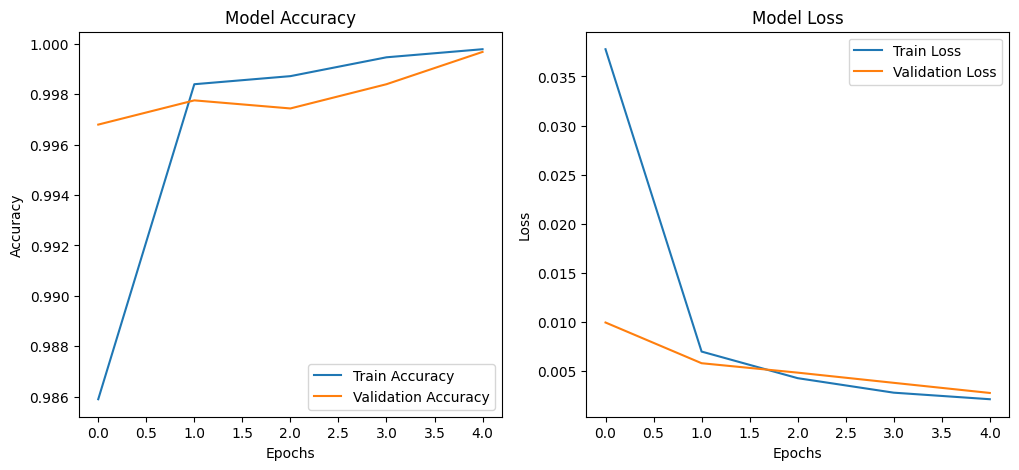

In [26]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

In [27]:
# Save the Trained model
model.save('tile_anomaly_detection_model.h5')